# 삼성전자 주가 그래프 작성

In [126]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/AAME.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.00,4.05,3.85,3.85,3.213167,15000
1,1980-03-18,0.00,4.00,3.80,3.80,3.171437,10200
2,1980-03-19,0.00,4.05,3.85,3.85,3.213167,33500
3,1980-03-20,0.00,4.00,3.80,3.80,3.171437,8700
4,1980-03-21,0.00,3.95,3.75,3.75,3.129709,12700
...,...,...,...,...,...,...,...
10093,2020-03-26,2.29,2.29,2.08,2.28,2.280000,1600
10094,2020-03-27,2.25,2.25,2.21,2.25,2.250000,500
10095,2020-03-30,2.25,2.25,2.13,2.13,2.130000,400
10096,2020-03-31,2.11,2.11,2.11,2.11,2.110000,300


In [128]:
# 'Date'를 datetime 형식으로 변환
df['Date'] = pd.to_datetime(df['Date'])

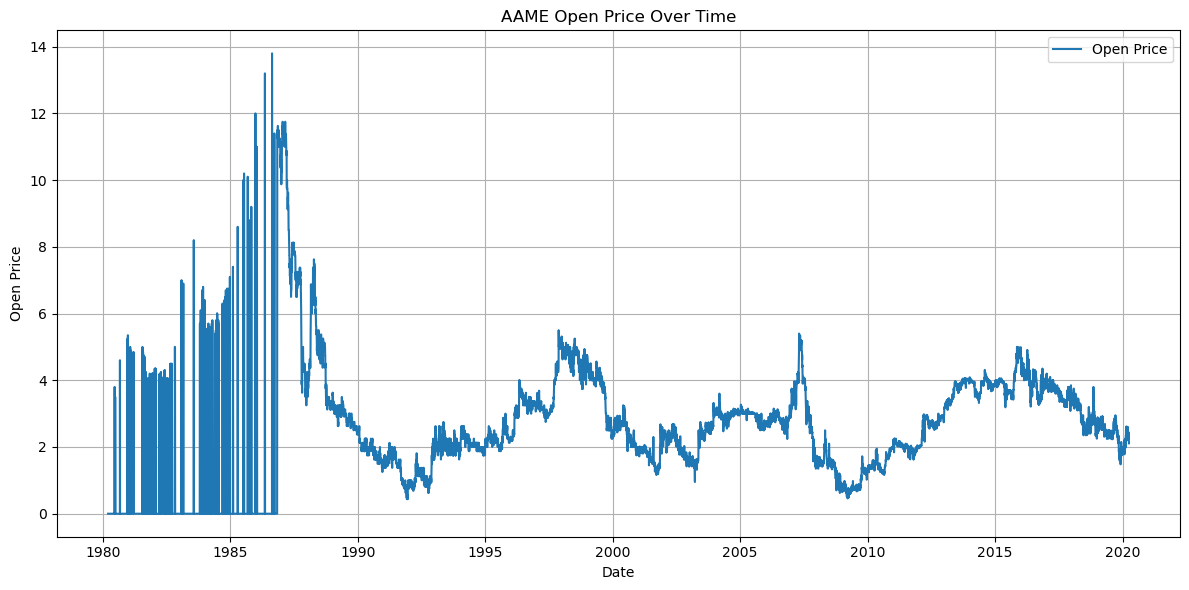

In [130]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'], label='Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('AAME Open Price Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [132]:
seq_data = (df[['Open']]).to_numpy()

def make_sample(data, window):
    train = []
    target = []
    for i in range(len(data) - window):
        train.append(data[i:i+window])
        target.append(data[i+window])
    return np.array(train), np.array(target)

X, y = make_sample(seq_data, 7)
print(X.shape, y.shape)
print(X[10000], y[10000]) # 앞의 데이터는 모두 Opne 값이 0이다.

(10091, 7, 1) (10091, 1)
[[1.89999998]
 [1.82000005]
 [1.75999999]
 [1.71000004]
 [1.70000005]
 [1.64999998]
 [1.60000002]] [1.76999998]


# RNN으로 모델 생성 및 예측

## 데이터셋 로드

In [137]:
df = pd.read_csv("https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/AAME.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.00,4.05,3.85,3.85,3.213167,15000
1,1980-03-18,0.00,4.00,3.80,3.80,3.171437,10200
2,1980-03-19,0.00,4.05,3.85,3.85,3.213167,33500
3,1980-03-20,0.00,4.00,3.80,3.80,3.171437,8700
4,1980-03-21,0.00,3.95,3.75,3.75,3.129709,12700
...,...,...,...,...,...,...,...
10093,2020-03-26,2.29,2.29,2.08,2.28,2.280000,1600
10094,2020-03-27,2.25,2.25,2.21,2.25,2.250000,500
10095,2020-03-30,2.25,2.25,2.13,2.13,2.130000,400
10096,2020-03-31,2.11,2.11,2.11,2.11,2.110000,300


In [138]:
# 예측에 필요 없는 Date와 Volume은 drop
df = df.drop(['Date', 'Volume'], axis=1)
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close'], dtype='object')


In [141]:
# 시작값만 가지고 예측하도록 openValues 지정
openValues = df[['Open']]

## 특징값 정규화

In [144]:
# MinMaxScaler 사용
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(openValues)

## 훈련 데이터와 테스트 데이터의 분리

In [147]:
# 200개의 훈련 데이터를 지정
# 나머지 데이터는 테스트 데이터로 지정
TEST_SIZE = 200
window_size = 30
train_data = scaled[:-TEST_SIZE]
test_data = scaled[-TEST_SIZE:]

## 순차 훈련 데이터 생성

In [150]:
def make_sample(data, window):
    X = []
    y = []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_train, y_train = make_sample(train_data, 30)

## RNN 구축

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler

model = Sequential()
model.add(SimpleRNN(16, input_shape=(window_size, 1), activation='tanh'))
model.add(Dense(1))

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 모델 학습

In [156]:
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.fit(X_train, y_train, epochs = 10, batch_size = 16)

Epoch 1/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0088
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0032
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0028
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0025
Epoch 5/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0030
Epoch 6/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026
Epoch 7/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0025
Epoch 8/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0027
Epoch 9/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0029
Epoch 10/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0025


In [157]:
X_test, y_test = make_sample(test_data, 30)
pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


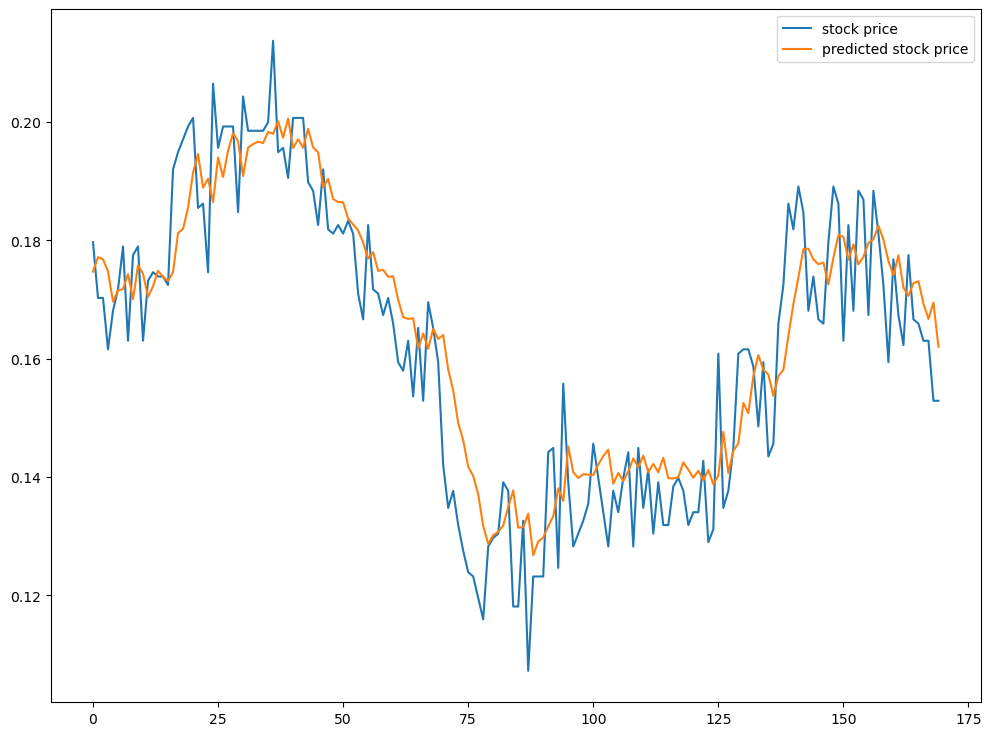

In [158]:
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='stock price')
plt.plot(pred, label='predicted stock price')
plt.legend()
plt.show()

## 성능 평가

In [169]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 스케일링 복원
pred_rescaled = scaler.inverse_transform(pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# 성능 측정
mse = mean_squared_error(y_test_rescaled, pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, pred_rescaled)
r2 = r2_score(y_test_rescaled, pred_rescaled)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.0195
RMSE: 0.1395
MAE: 0.1146
R² Score: 0.8320
